# Spectral type flagger and star physical quantities Probability Distribution Functions (star-PDF)

In [1]:
### Import libraries ###
import re
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In another script, we developped a PDFstar flagger which assumes the spectral type of a star by looking at the best fit of a onesource object over a star template. We used a 1 dimensional, and limited, sed lib which was to cover smoothly the entire specter of star spectral-types (from O to M and with a few white dwarves). 

Looking at the functionning of Lephare to determine photo-z, when we use the minimal Chi2 method, we determine the type of galaxy at a pecular redshift, so we fit a source to a 2D grid.

Aside that, there is three main quantities that determine the atmosphere of a star : Surface temperature (**Teff**), Mass or gravity (**log(g)**) and composition or metallicity (**Fe/H**).

Taking these informations into account, we can use the same logic as the one used to compute the photo-z of a source but to determine the spectral-type of a star. Hence, this time we want to use a more complete 2D or 3D grid of star sed.

Thus we pre-made a star sed library for Lephare that covers every knew type of star with those physical quantities, and run lephare onto it.

To works, it is important to have written the specs of the utilized seds either in the respective file name or in a commmented header. 

## The SED grid(s)

Note: sed grids are not perfectly square or cubic: some simulated sed are unrealistic, for example it is unsual to see a O-type star with a high metallicity. It would be a loss of time to compute the minimal Chi2 of a fit of a onesource to such a sed. Thus the sed grids are truncated at specific Teff values.

**Teff** vs **log(g)** vs **Fe/H**

In [2]:
### sed grid class

class SED_GRID:
    def __init__(self, list_path):
        """Load SED list."""
        sed_list = []
        with open(list_path, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('#') or not line:
                    continue
                filepath = line.split()[0]
                sp_type = filepath.split('/')[-1].replace('.sed', "")
                sed_list.append(sp_type)
        self.sed_list = sed_list
        self.sed_grid = None

    def build(self):
        """Build the sed grid [Id, Teff, logg, FeH] from filenames."""
        pattern = r"Teff([-\d\.]+)_logg([-\d\.]+)_FeH([-\d\.]+)"
        sed_grid = []
        for Id, s in enumerate(self.sed_list):
            match = re.search(pattern, s)
            if match:
                Teff, logg, FeH = match.groups()
                Teff, logg, FeH = float(Teff), float(logg), float(FeH)
                sed_grid.append([Id, Teff, logg, FeH])
        self.sed_grid = np.array(sed_grid)
        return self.sed_grid

    def plot(self, cmap='gnuplot'):
        """Plot 3D SED grid with color depending on FeH."""
        if self.sed_grid is None:
            raise ValueError("Call make_sed_grid before plot.")

        Teff, logg, FeH = self.sed_grid[:, 1], self.sed_grid[:, 2], self.sed_grid[:, 3]

        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(projection='3d')

        # Couleur selon la métallicité
        sc = ax.scatter(
            Teff, logg, FeH,
            c=FeH, cmap=cmap,
            alpha=0.8, s=10, edgecolor="none"
        )

        # Colorbar
        cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink=0.8)
        cbar.set_label('[Fe/H]', rotation=270, labelpad=15)

        ax.set_xlabel('Teff [K]')
        ax.set_ylabel('log(g)')
        ax.set_zlabel('[Fe/H]')
        ax.set_title("SED Grid Colored by Metallicity")

        # Optionnel : meilleure orientation par défaut
        ax.view_init(elev=20, azim=-45)

        plt.tight_layout()
        plt.show()

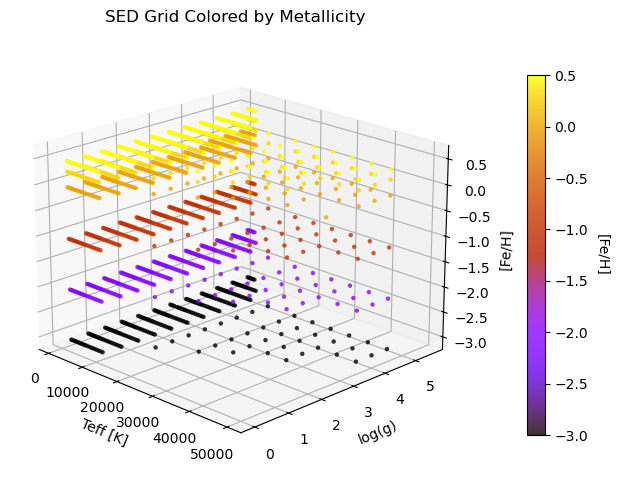

In [3]:
# %matplotlib widget
sed_grid_init = SED_GRID('/home/hallouin/Documents/t_hall/lephare/simulated_star_sed/bt_spectra/bt_star_sed_full.list')
sed_grid = sed_grid_init.build()
sed_grid_init.plot()

## Retrieving full star Chi2 distribution

During its processing, the only way to identify which template(s) has been used to compute the quantities relative to a onesource it's their Id. This Id is assigned when creating the sed library (with the SedLib part of the code), and is useful to retrieve the sed during or at the end of the process. 

A notable difference between the PDZ and the star-PDF is that the first one is computed from a grid that has been created thanks to the MagLab part of the code, while the star-PDF will be made from a already full 2D or 3D grid. Which means that we need to "remember" the Id of each seds to re-order them in the good way to have a smooth functionning PDF.



So first we need functions to retrieve the physical quanities relative to a sed (**Teff**, **log(g)** and **Fe/H**) thanks to its Id.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

class STAR_PDF_VISUALIZER:
    def __init__(self, sed_grid_obj):
        if sed_grid_obj.sed_grid is None:
            raise ValueError("SED_GRID: call build() before using STAR_PDF_VISUALIZER.")

        self.sed_grid = sed_grid_obj.sed_grid   # base grid
        self.chi2_grid = None                   # will be built later

    # ------------------------------------------------------------------
    def build_chi2_grid(self, chi2_array):
        """Attach chi2 array to SED grid."""
        if len(chi2_array) != len(self.sed_grid):
            raise ValueError("chi2 array length does not match sed_grid length.")

        self.chi2_grid = np.column_stack((self.sed_grid, chi2_array))
        return self.chi2_grid

    # ------------------------------------------------------------------
    def project_min_chi2(self, xaxis="Teff", yaxis=None, to_prob=False, fixed=None):
        """
        Project Chi² parallel to one or two axes.
        Uses self.chi2_grid automatically.
        """
        if self.chi2_grid is None:
            raise ValueError("Call build_chi2_grid before projecting.")

        grid = self.chi2_grid
        columns = ["Id", "Teff", "logg", "FeH", "Chi2"]
        col_idx = {k: i for i, k in enumerate(columns)}

        # 1) Apply fixed filters
        mask = np.ones(len(grid), dtype=bool)
        if fixed:
            for key, val in fixed.items():
                mask &= np.isclose(grid[:, col_idx[key]], val)
            grid = grid[mask]
            if len(grid) == 0:
                raise ValueError("No grid point matches the given fixed conditions.")

        xcol = col_idx[xaxis]

        if yaxis:   # ----------- 2D PROJECTION -------------
            ycol = col_idx[yaxis]

            X_vals = np.unique(grid[:, xcol])
            Y_vals = np.unique(grid[:, ycol])
            Z = np.full((len(Y_vals), len(X_vals)), np.nan)

            for i, xv in enumerate(X_vals):
                for j, yv in enumerate(Y_vals):
                    mask_xy = np.isclose(grid[:, xcol], xv) & np.isclose(grid[:, ycol], yv)
                    if np.any(mask_xy):
                        Z[j, i] = np.nanmin(grid[mask_xy, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))

            return X_vals, Y_vals, Z

        else:       # ----------- 1D PROJECTION -------------
            X_vals = np.unique(grid[:, xcol])
            Z = np.full(len(X_vals), np.nan)

            for i, xv in enumerate(X_vals):
                mask_x = np.isclose(grid[:, xcol], xv)
                if np.any(mask_x):
                    Z[i] = np.nanmin(grid[mask_x, -1])

            if to_prob:
                Zmin = np.nanmin(Z)
                Z = np.exp(-0.5 * (Z - Zmin))

            return X_vals, Z

    # ------------------------------------------------------------------
    def plot_min_chi2(self, xaxis="Teff", yaxis=None, to_prob=False,
                      full=False, cmap='gnuplot', fixed=None):

        if self.chi2_grid is None:
            raise ValueError("Call build_chi2_grid before plotting.")

        grid = self.chi2_grid  # just to avoid rewriting this everywhere

        # ---------- FULL CORNER-PLOT ----------
        if full:
            axes = ["Teff", "logg", "FeH"]
            n = len(axes)

            # Pré-calculer les plages de valeurs pour uniformiser les axes
            limits = {}
            for ax in axes:
                limits[ax] = np.unique(grid[:, {"Teff": 1, "logg": 2, "FeH": 3}[ax]])
            
            fig = plt.figure(figsize=(8, 8))
            gs = plt.GridSpec(n, n, wspace=0.0, hspace=0.0)

            for i in range(n):  # ligne
                for j in range(n):  # colonne
                    if j > i:
                        continue
                    ax = fig.add_subplot(gs[i, j])

                    if i == j:
                        # --- PDF 1D ---
                        X, Z = self.project_min_chi2(xaxis=axes[j], to_prob=to_prob, fixed=fixed)
                        ax.plot(X, Z, color='black', lw=1)
                        # ax.fill_between(X, Z, color='C0', alpha=0.4)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(Z.min() * 0.95, Z.max() * 1.05)
                        if i < n - 1:
                            ax.set_xticklabels([])
                        if i != 0:
                            ax.yaxis.tick_right()
                        else:
                            ax.set_xlabel(axes[j])

                    else:
                        # --- PDF 2D ---
                        X, Y, Z = self.project_min_chi2(xaxis=axes[j], yaxis=axes[i], fixed=fixed)
                        if to_prob:
                            Z = np.exp(-0.5 * (Z - np.nanmin(Z)))
                        im = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
                        ax.set_xlim(limits[axes[j]].min(), limits[axes[j]].max())
                        ax.set_ylim(limits[axes[i]].min(), limits[axes[i]].max())
                        if i < n - 1:
                            ax.set_xticklabels([])
                        else:
                            ax.set_xlabel(axes[j])
                        if j > 0:
                            ax.set_yticklabels([])
                        else:
                            ax.set_ylabel(axes[i])

            # Colorbar
            cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label("Probability" if to_prob else "min(χ²)")
            plt.subplots_adjust(left=0.08, right=0.9, top=0.9, bottom=0.08)
            plt.show()
            return


        # --- Single plot mode
        if yaxis:
            X, Y, Z = self.project_min_chi2(xaxis, yaxis, to_prob=to_prob, fixed=fixed)
            plt.figure(figsize=(6, 4))
            plt.pcolormesh(X, Y, Z, shading='auto')
            plt.colorbar(label="Probability" if to_prob else "min(Chi²)")
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.title(f"Minimized Chi² map")
            plt.show()
        else:
            X, Z = self.project_min_chi2(xaxis, to_prob=to_prob, fixed=fixed)
            plt.figure(figsize=(6, 3))
            plt.plot(X, Z, marker='o', lw=1)
            plt.xlabel(xaxis)
            plt.ylabel("Probability" if to_prob else "min(Chi²)")
            plt.title("Minimized Chi² PDF")
            plt.grid(True)
            plt.show()



In [47]:
chi2_values = np.loadtxt("/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DESstars_BT_DES_full_PDFstar.prob")
# chi2_values = np.loadtxt("/home/hallouin/Documents/t_hall/lephare/training_stats/simulation_catalogs/star_gal/PDFs/DC1_BT_LSST_full_PDFstar.prob")

## PDF examples

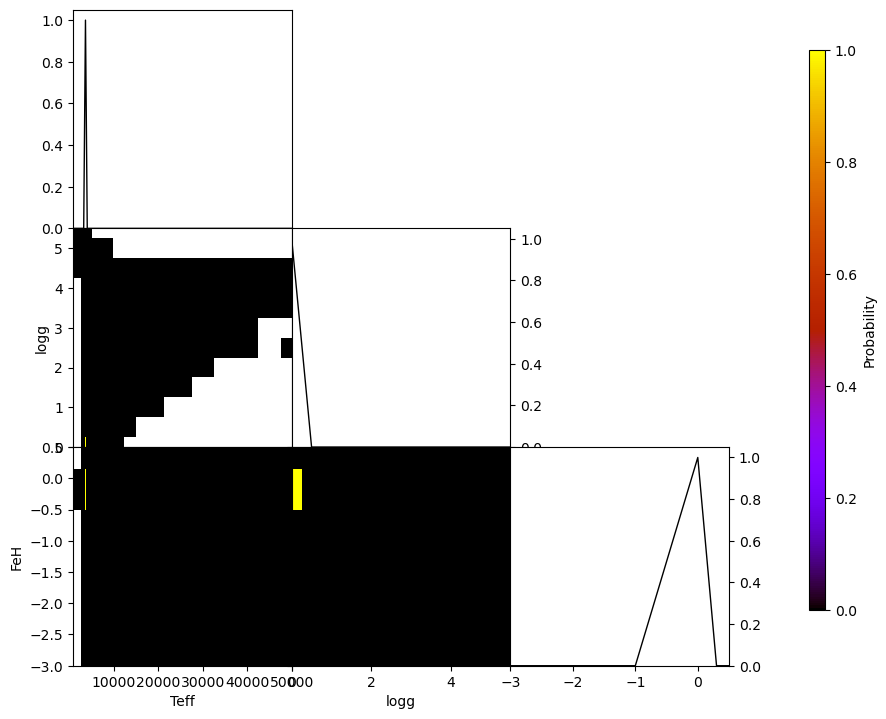

In [65]:
star_pdf_visualizer = STAR_PDF_VISUALIZER(sed_grid_init)
chi2_grid = star_pdf_visualizer.build_chi2_grid(chi2_values[82,1:])
star_pdf_visualizer.plot_min_chi2(to_prob=True, full=True)#, fixed={"Teff": 7200})

## PDF Analyzer

In [60]:
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter


class STAR_PDF_ANALYZER:
    """
    Analyse a chi2_grid (Nx5 array: [Id, Teff, logg, FeH, Chi2])
    and extract a vector of features useful to discriminate star vs galaxy.

    Usage:
        analyzer = STAR_PDF_ANALYZER(chi2_grid, to_prob=True)
        feats = analyzer.compute_all_features()
    """

    def __init__(self, chi2_grid, to_prob=False):
        # Basic checks
        chi2_grid = np.asarray(chi2_grid)
        if chi2_grid.ndim != 2 or chi2_grid.shape[1] < 5:
            raise ValueError("chi2_grid must be shape (N,>=5) with columns [Id,Teff,logg,FeH,Chi2].")

        self.grid = chi2_grid.copy()
        self.to_prob = bool(to_prob)

        # column indices
        self.col = {"Id": 0, "Teff": 1, "logg": 2, "FeH": 3, "Chi2": 4}

        # precompute basic quantities
        self.chi2_min_global = float(np.nanmin(self.grid[:, self.col["Chi2"]]))
        self.P3 = None  # 3D probability (flattened over grid rows)
        if self.to_prob:
            self._make_prob3d()

    # -------------------------
    # Internal helpers
    # -------------------------
    def _make_prob3d(self):
        """Compute 3D probability P_i = exp(-0.5*(chi2 - chi2_min)) normalized over all grid points."""
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        dchi2 = chi2 - np.nanmin(chi2)
        # prevent overflow/underflow
        with np.errstate(over="ignore", invalid="ignore"):
            P = np.exp(-0.5 * dchi2)
        P[np.isnan(P)] = 0.0
        s = P.sum()
        if s <= 0:
            P = np.zeros_like(P)
        else:
            P = P / s
        self.P3 = P
        return P

    def _project_1d(self, axis, to_prob=None, fixed=None):
        """
        Build projected 1D array along axis by taking min_chi2 over other two dims.
        Returns (X_vals_sorted, Z_vals) where Z is either min_chi2 (if to_prob False)
        or normalized probability (if to_prob True).
        fixed: dict of fixed parameters e.g. {"FeH":0.0} to restrict points before projection.
        """
        if to_prob is None:
            to_prob = self.to_prob

        col_idx = self.col[axis]
        # apply fixed mask if any
        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)
        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([])

        X_vals = np.unique(sub[:, col_idx])
        X_vals.sort()
        Z = np.full(len(X_vals), np.nan)
        # For each X, find min chi2 over remaining dims
        for i, xv in enumerate(X_vals):
            sel = np.isclose(sub[:, col_idx], xv)
            if not np.any(sel):
                continue
            Z[i] = np.nanmin(sub[sel, self.col["Chi2"]])

        if to_prob:
            # convert to prob using local min to avoid underflow and normalize
            if np.all(np.isnan(Z)):
                return X_vals, Z
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = P.sum()
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return X_vals, P
        else:
            return X_vals, Z

    def _project_2d(self, xaxis, yaxis, to_prob=None, fixed=None):
        """
        Build projected 2D grid by taking min chi2 over third axis.
        Returns (X_vals_sorted, Y_vals_sorted, Z (shape (len(Y), len(X))))
        Z is min_chi2 if to_prob False, else normalized prob on the 2D grid.
        """
        if to_prob is None:
            to_prob = self.to_prob

        xi = self.col[xaxis]
        yi = self.col[yaxis]
        # third axis
        axes = {"Teff", "logg", "FeH"}
        third = list(axes - {xaxis, yaxis})[0]
        ti = self.col[third]

        mask = np.ones(len(self.grid), dtype=bool)
        if fixed:
            for k, v in fixed.items():
                if k not in self.col:
                    raise ValueError(f"Unknown fixed axis '{k}'")
                mask &= np.isclose(self.grid[:, self.col[k]], v)

        sub = self.grid[mask]
        if sub.size == 0:
            return np.array([]), np.array([]), np.array([[]])

        X_vals = np.unique(sub[:, xi]); X_vals.sort()
        Y_vals = np.unique(sub[:, yi]); Y_vals.sort()

        Z = np.full((len(Y_vals), len(X_vals)), np.nan)

        for i, xv in enumerate(X_vals):
            for j, yv in enumerate(Y_vals):
                sel = np.isclose(sub[:, xi], xv) & np.isclose(sub[:, yi], yv)
                if not np.any(sel):
                    continue
                Z[j, i] = np.nanmin(sub[sel, self.col["Chi2"]])

        if to_prob:
            if np.all(np.isnan(Z)):
                return X_vals, Y_vals, Z
            # convert local to probability and normalize over the grid
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                P = np.exp(-0.5 * dchi)
            P[np.isnan(P)] = 0.0
            s = np.nansum(P)
            if s > 0:
                P = P / s
            else:
                P = np.zeros_like(P)
            return X_vals, Y_vals, P
        else:
            return X_vals, Y_vals, Z

    # -------------------------
    # 1D metrics
    # -------------------------
    def npeaks_1d(self, axis, threshold=0.5, fixed=None):
        """
        Number of significant peaks in 1D projected PDF.
        threshold: fraction of max used for peak detection (height)
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        # operate on Z whether it is prob or chi2 (if chi2, invert to make peaks)
        if self.to_prob:
            arr = Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))
        else:
            # invert chi2 to find minima as peaks
            arr = -Z
            height = threshold * np.nanmax(arr)
            peaks, _ = find_peaks(arr, height=height)
            return int(len(peaks))

    def peakratio_1d(self, axis, fixed=None):
        """
        mean(Z) / max(Z) where Z is probability (if to_prob True) or exp(-0.5*(chi2-localmin)) normalized.
        We return (mean/max) which is small for peaked distributions.
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        if np.nanmax(Z) == 0:
            return -99
        return float(np.nanmean(Z) / np.nanmax(Z))

    def std_1d(self, axis, fixed=None):
        """
        Weighted standard deviation of the 1D PDF around its normalized distribution.
        If to_prob=False we convert to prob-like weighting using exp(-0.5*(Z - Zmin)).
        """
        X, Z = self._project_1d(axis, to_prob=self.to_prob, fixed=fixed)
        if Z.size == 0:
            return -99
        # if Z is chi2 minima (to_prob False), convert to weights
        if not self.to_prob:
            if np.all(np.isnan(Z)):
                return -99
            dchi = Z - np.nanmin(Z)
            with np.errstate(over="ignore", invalid="ignore"):
                W = np.exp(-0.5 * dchi)
            W[np.isnan(W)] = 0.0
            s = W.sum()
            if s > 0:
                W = W / s
            else:
                W = np.zeros_like(W)
        else:
            W = Z.copy()
        if np.nansum(W) <= 0:
            return -99
        mean = np.nansum(X * W)
        var = np.nansum(((X - mean) ** 2) * W)
        return float(np.sqrt(var))

    # -------------------------
    # 2D metrics
    # -------------------------
    def cov_2d(self, xaxis, yaxis, fixed=None):
        """
        Compute weighted covariance matrix of the 2D projected probability map.
        Returns (cov_xx, cov_yy, cov_xy, axis_ratio) where axis_ratio = sqrt(largest_eig / smallest_eig)
        If to_prob False, will convert projection to probabilities internally.
        """
        X, Y, P = self._project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return (-99, -99, -99, -99)

        # Flatten and compute weighted covariance
        Xg, Yg = np.meshgrid(X, Y)  # shape (len(Y), len(X))
        W = np.array(P, dtype=float)
        W = W / (np.nansum(W) + 1e-300)

        x_flat = Xg.ravel()
        y_flat = Yg.ravel()
        w_flat = W.ravel()

        # Only keep positive weight points
        good = w_flat > 0
        if np.sum(good) == 0:
            return (-99, -99, -99, -99)
        x_flat = x_flat[good]; y_flat = y_flat[good]; w_flat = w_flat[good]

        mean_x = np.sum(x_flat * w_flat)
        mean_y = np.sum(y_flat * w_flat)

        cov_xx = np.sum(w_flat * (x_flat - mean_x) ** 2)
        cov_yy = np.sum(w_flat * (y_flat - mean_y) ** 2)
        cov_xy = np.sum(w_flat * (x_flat - mean_x) * (y_flat - mean_y))

        # eigenvalues of covariance 2x2
        cov_mat = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])
        try:
            eigvals = np.linalg.eigvalsh(cov_mat)
            eigvals = np.maximum(eigvals, 1e-300)
            axis_ratio = float(np.sqrt(eigvals[-1] / eigvals[0])) if eigvals[0] > 0 else float(np.inf)
        except Exception:
            axis_ratio = -99

        return float(cov_xx), float(cov_yy), float(cov_xy), float(axis_ratio)

    def area_highprob_2d(self, xaxis, yaxis, threshold=0.5, fixed=None):
        """
        Fraction of (x,y) grid cells where P(x,y) >= threshold * Pmax.
        Returns fraction in [0,1].
        """
        X, Y, P = self._project_2d(xaxis, yaxis, to_prob=self.to_prob, fixed=fixed)
        if P.size == 0:
            return -99.0
        Pmax = np.nanmax(P)
        if Pmax <= 0:
            return 0.0
        mask = P >= (threshold * Pmax)
        # fraction of valid grid cells (consider only non-nan cells)
        valid = ~np.isnan(P)
        if np.sum(valid) == 0:
            return -99.0
        frac = np.sum(mask & valid) / np.sum(valid)
        return float(frac)

    # -------------------------
    # Global metrics
    # -------------------------
    def entropy(self):
        """
        Entropy of the full 3D probability distribution (in nats).
        H = - sum_i P_i log P_i
        """
        if self.P3 is None:
            self._make_prob3d()
        P = np.array(self.P3, dtype=float)
        # filter zeros
        mask = P > 0
        if np.sum(mask) == 0:
            return -99.0
        H = -np.sum(P[mask] * np.log(P[mask]))
        return float(H)

    def concentration(self, delta_chi2=1.0):
        """
        Fraction of total probability contained in chi2 <= chi2_min_global + delta_chi2.
        """
        chi2 = self.grid[:, self.col["Chi2"]].astype(float)
        if self.P3 is None:
            self._make_prob3d()
        mask = chi2 <= (self.chi2_min_global + float(delta_chi2))
        if np.sum(mask) == 0:
            return 0.0
        return float(np.sum(self.P3[mask]))

    def delta_chi2(self):
        """
        Difference between second-best chi2 and best chi2 (global).
        """
        chi2 = np.array(self.grid[:, self.col["Chi2"]], dtype=float)
        if chi2.size < 2:
            return -99.0
        sorted_chi = np.sort(chi2)
        d = float(sorted_chi[1] - sorted_chi[0])
        return d

    # -------------------------
    # Main orchestrator
    # -------------------------
    def compute_all_features(self, fixed=None):
        """
        Compute a dictionary with all features:
          - 1D: npeaks, peakratio, std  (for Teff, logg, FeH)
          - 2D: covariances and axis_ratio, area_highprob for each pair
          - global: entropy, concentration (delta_chi2=1), delta_chi2
        fixed: optional dict to restrict analysis to a slice before projecting.
        """
        feats = {}

        # 1D features
        for ax in ["Teff", "logg", "FeH"]:
            feats[f"npeaks_{ax}"] = self.npeaks_1d(ax, threshold=0.2, fixed=fixed)
            feats[f"peakratio_{ax}"] = self.peakratio_1d(ax, fixed=fixed)
            feats[f"std_{ax}"] = self.std_1d(ax, fixed=fixed)

        # 2D features: pairs
        pairs = [("Teff", "logg"), ("Teff", "FeH"), ("logg", "FeH")]
        for (x, y) in pairs:
            cov_xx, cov_yy, cov_xy, axis_ratio = self.cov_2d(x, y, fixed=fixed)
            feats[f"cov_{x}_{y}_xx"] = cov_xx
            feats[f"cov_{x}_{y}_yy"] = cov_yy
            feats[f"cov_{x}_{y}_xy"] = cov_xy
            feats[f"axisratio_{x}_{y}"] = axis_ratio
            feats[f"area_{x}_{y}_p50"] = self.area_highprob_2d(x, y, threshold=0.5, fixed=fixed)
            feats[f"area_{x}_{y}_p90"] = self.area_highprob_2d(x, y, threshold=0.9, fixed=fixed)

        # global features
        feats["entropy"] = self.entropy()
        feats["concentration_dchi2_1"] = self.concentration(delta_chi2=1.0)
        feats["delta_chi2"] = self.delta_chi2()

        return feats


In [66]:
star_pdf_analyzer = STAR_PDF_ANALYZER(chi2_grid)
star_pdf_analyzer.compute_all_features()

{'npeaks_Teff': 0,
 'peakratio_Teff': 0.6127657938736658,
 'std_Teff': 0.0,
 'npeaks_logg': 0,
 'peakratio_logg': 0.3969362612205555,
 'std_logg': 4.8157697801470815e-84,
 'npeaks_FeH': 0,
 'peakratio_FeH': 0.4627860310062465,
 'std_FeH': 4.377972527406438e-85,
 'cov_Teff_logg_xx': 125282862.1665717,
 'cov_Teff_logg_yy': 2.26387068790138,
 'cov_Teff_logg_xy': 2809.275347595038,
 'axisratio_Teff_logg': 7544.803726265192,
 'area_Teff_logg_p50': 0.6302816901408451,
 'area_Teff_logg_p90': 0.23943661971830985,
 'cov_Teff_FeH_xx': 204353711.4960279,
 'cov_Teff_FeH_yy': 1.618112647839074,
 'cov_Teff_FeH_xy': -231.0603563280137,
 'axisratio_Teff_FeH': 11238.85198559019,
 'area_Teff_FeH_p50': 0.6994219653179191,
 'area_Teff_FeH_p90': 0.26011560693641617,
 'cov_logg_FeH_xx': 2.2621593631253996,
 'cov_logg_FeH_yy': 1.5093026741716664,
 'cov_logg_FeH_xy': -0.3277243737842167,
 'axisratio_logg_FeH': 1.3114403366486471,
 'area_logg_FeH_p50': 0.19444444444444445,
 'area_logg_FeH_p90': 0.0555555555555